# Reference level optimization
In scenarios where you have no prior knowledge of the elevation of the density contrast of interest, we use a flat starting model with an arbitrary reference level. The reference level (`zref`) is very important to the inversion as different values can vertically shift the inverted topography. Here we present a optimization approach to determine the optimal value for `zref`. This follows the same approach as the [density optimization notebook](05_density_optimization.ipynb). To simplify, we assume we know the appropriate density contrast value to use. 

## Import packages

In [1]:
import pathlib
import pickle

import numpy as np
import polartoolkit as ptk
import verde as vd

import invert4geom

/home/mdtanker/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Create observed gravity data

### True topography

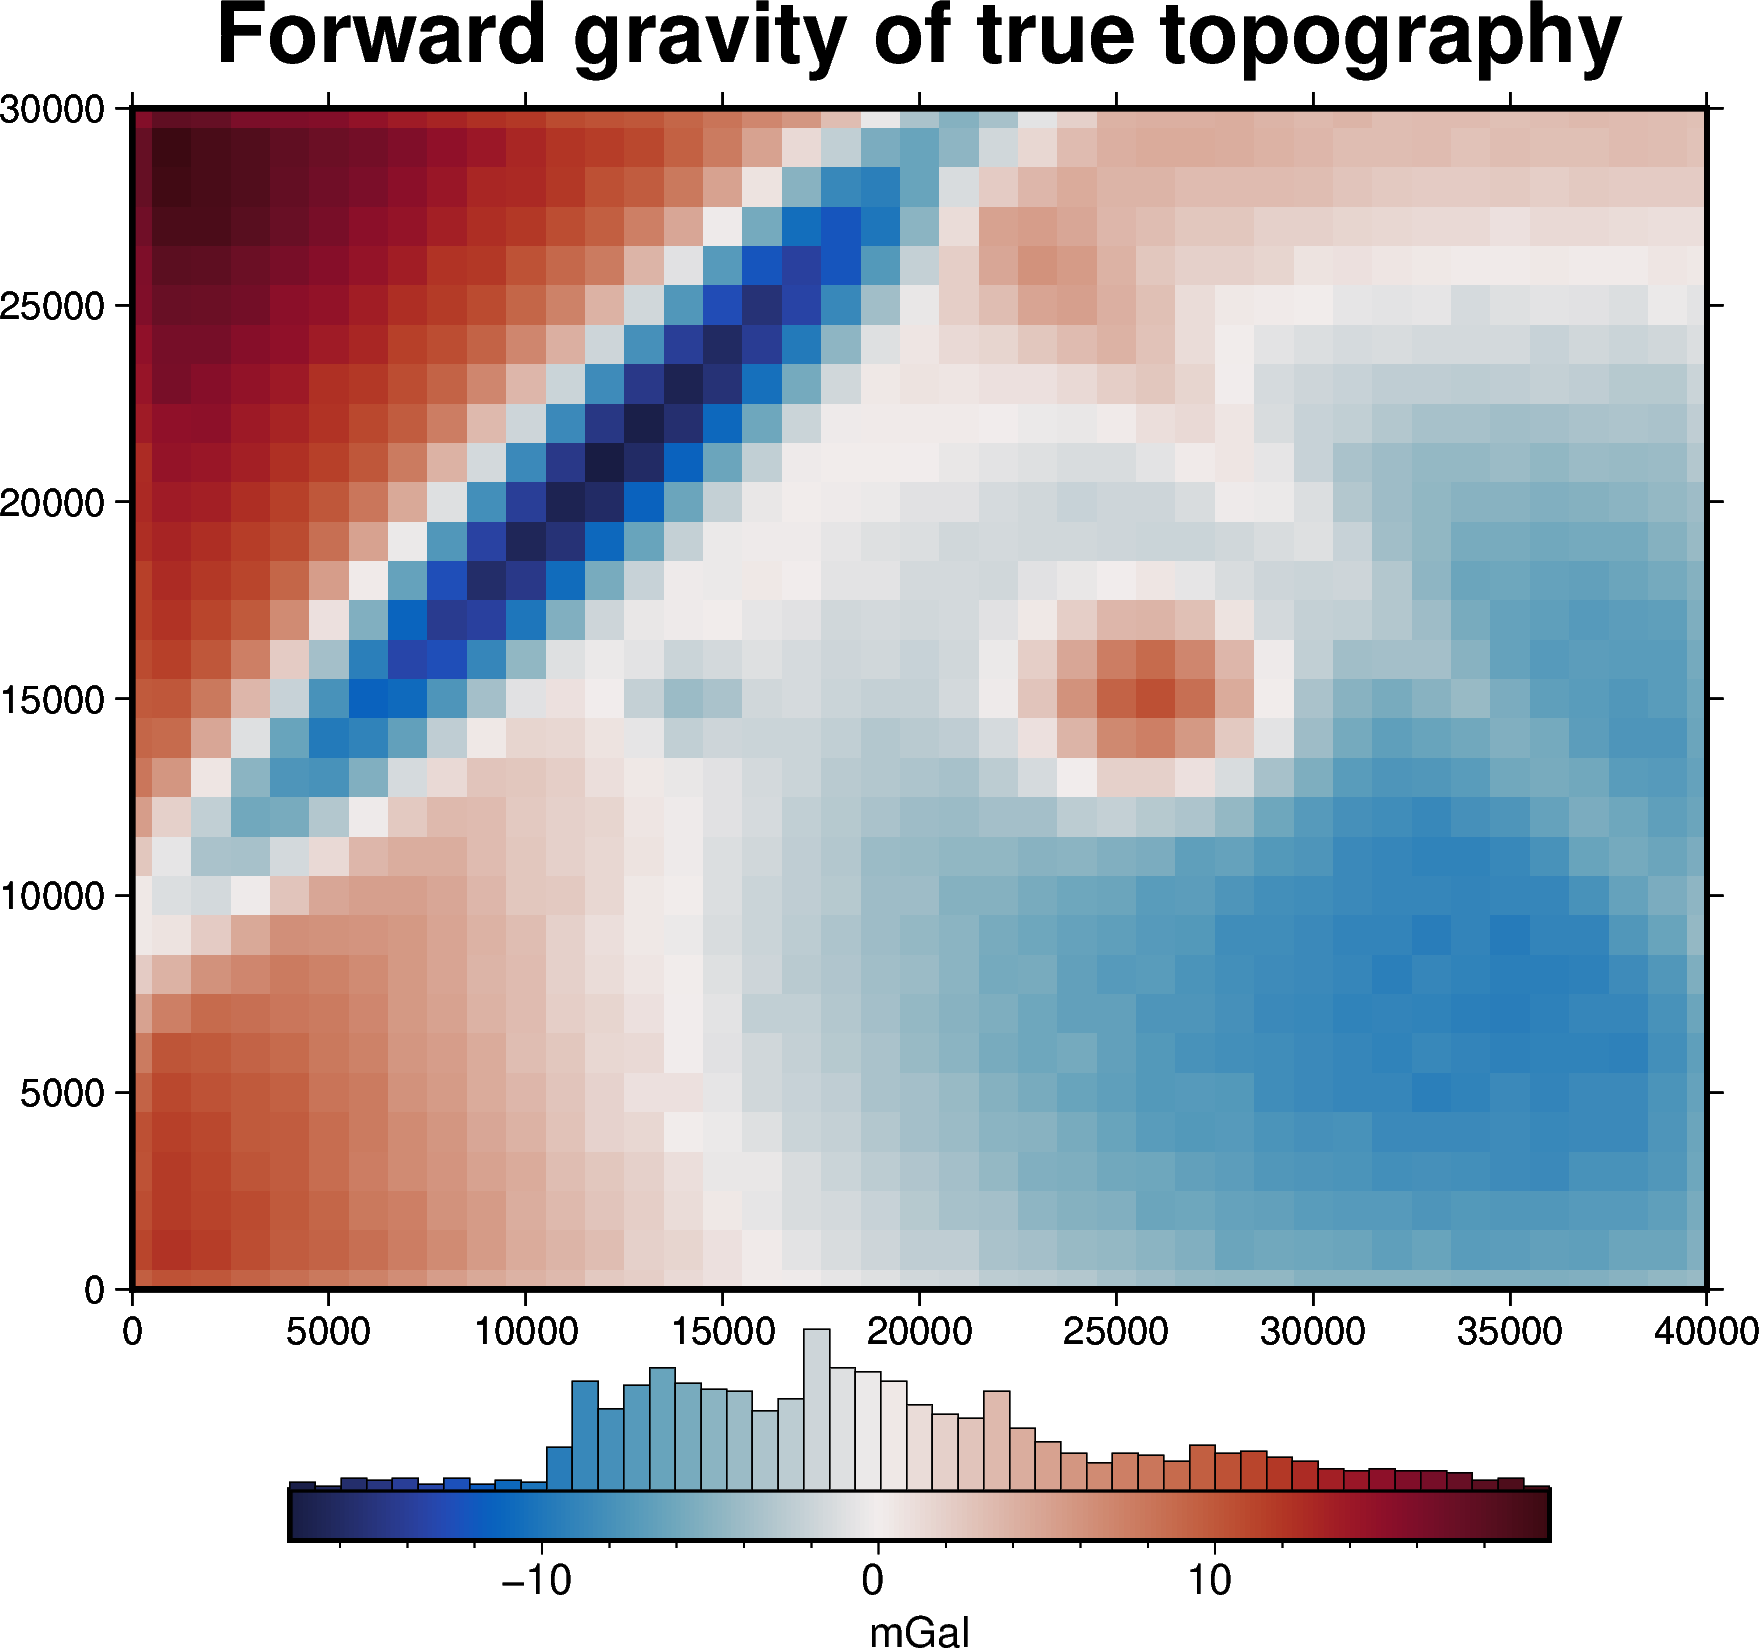

mean of true topography: 492.2704164812973 m 


In [2]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
true_density_contrast = 2670 - 1
(
    true_topography,
    _,
    constraint_points,
    observed_gravity,
) = invert4geom.load_synthetic_model(
    spacing=1000,
    region=(0, 40000, 0, 30000),
    number_of_constraints=10,
    density_contrast=true_density_contrast,
    gravity_noise=0.2,
    plot_topography_diff=False,
)

true_zref = true_topography.values.mean()
print(f"mean of true topography: {true_zref} m ")

For simplicity here we assume that we know the optimal density contrast value and use this when creating our starting model.

What we don't know in this scenario is what reference elevation `zref` to use. We will use an optimization of a range of elevations to find the one which is optimal.

Each `zref` will give a score, and the lowest score will show which `zref` is optimal. 

The score is calculated as the root mean square error between the points of known topography (`constraints`) and the inverted topography at those points, same as in the past notebook. 

## Get a score

First we need to use the `zref` value to create the starting model. We will then use this in an inversion to calculate a `score`.

In [3]:
data = invert4geom.create_data(observed_gravity)

# make a flat grid at the height of the zref
grid_coords = vd.grid_coordinates(region=data.region, spacing=data.spacing)
starting_topography = vd.make_xarray_grid(
    grid_coords, data=np.ones_like(grid_coords[0]) * true_zref, data_names="upward"
)

model = invert4geom.create_model(
    zref=300,  # instead of the correct value of ~490 m,
    density_contrast=true_density_contrast,
    topography=starting_topography,
)

In [4]:
data.inv.forward_gravity(
    model,
    progressbar=True,
)

  0%|                                          | 0/1271 [00:00<?, ?it/s]

In many cases, we want to remove a regional signal from the misfit to isolate the residual signal. In this simple case, we assume there is no regional misfit and set it to 0

In [5]:
data.inv.regional_separation(
    method="constant",
    constant=0,
)

makecpt [ERROR]: Option T: min >= max


supplied min value is greater or equal to max value


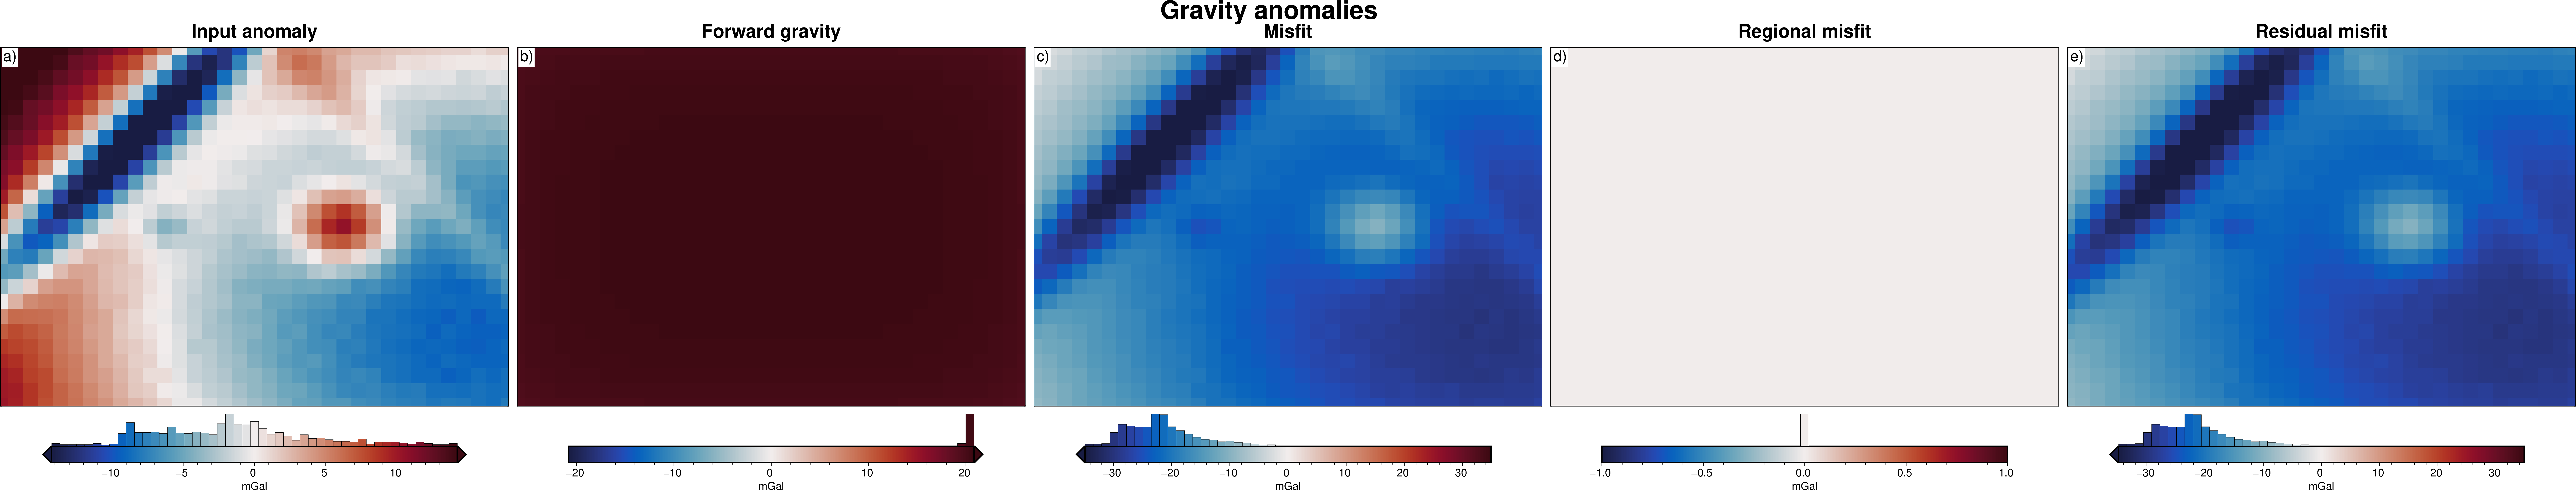

In [6]:
data.inv.plot_anomalies()

In [7]:
# setup the inversion
inv = invert4geom.Inversion(
    data,
    model,
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=0.45,
    delta_l2_norm_tolerance=1.005,
)

In [8]:
# run inversion, calculate the score
constraints_optimization_object = inv.constraints_score(
    constraints_df=constraint_points
)
inv.constraints_best_score

np.float64(195.01017866988633)

## Optimization
Lets see if we can improve the score with other values for zref. For each zref value we need to recreate the starting prism model, forward calculate its starting gravity, and recalculate the gravity misfit, including the regional and residual components. Then we can re-run the inversion.

This is a classic optimization problem, where we vary the zref to find which value produces the best score. For this we use the Python package [Optuna](https://optuna.readthedocs.io/en/stable/index.html). 

For each trial a `.pickle` file containing the inversion results will be created. Once all trials are complete, all but the best trial's pickle files will be deleted. Additionally, another `.pickle` file will be created containing the Optuna study object with all the trial information and results.

By default, `optimize_inversion_zref_density_contrast` will use a sampler to choose zref values between the provided `zref_limits` and repeat this `n_trials` times. This may skip large portions of the parameter space. If instead you would like to systematically test zref values at a constant interval, you can set `grid_search` to True, and this will test all zref values as defined by:

```python
np.linspace(<<lower zref limit>>, <<upper zref limit>>, n_trials)
```

In [9]:
density_optimization_obj = inv.optimize_inversion_zref_density_contrast(
    constraints_df=constraint_points,
    zref_limits=(400, 600),
    n_trials=6,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    starting_topography_kwargs={
        "method": "flat",
        "region": inv.model.region,
        "spacing": inv.model.spacing,
    },
    # grid_search=True,
    plot_scores=False,
    fname="../tmp/06_zref_optimization",
    fold_progressbar=True,
)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

'forward_gravity' already a variable of `grav_ds`, but is being overwritten since calculate_starting_gravity is True


'reg' already a column of `grav_df`, but is being overwritten since calculate_regional_misfit is True


In [10]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/06_zref_optimization_study.pickle").open("rb") as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path("../tmp/06_zref_optimization.pickle").open("rb") as f:
    inv_results = pickle.load(f)

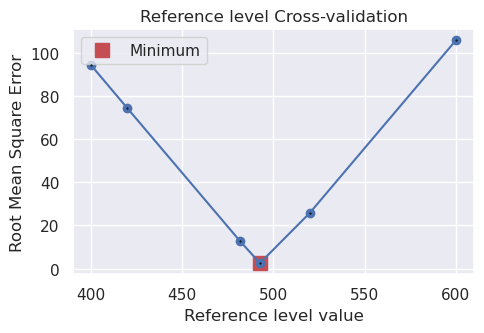

In [11]:
fig = invert4geom.plot_scores(
    study.trials_dataframe().value.values,
    study.trials_dataframe().params_zref.values,
    param_name="Reference level",
    logx=False,
    logy=False,
)

Lets see how the optimization perform by comparing the estimated `best` reference level value to the true value used to create the observed gravity.

In [12]:
print(
    f"True zref value: {true_zref}, best zref from optimization: {inv_results.model.zref}"
)

True zref value: 492.2704164812973, best zref from optimization: 492.53462017201565


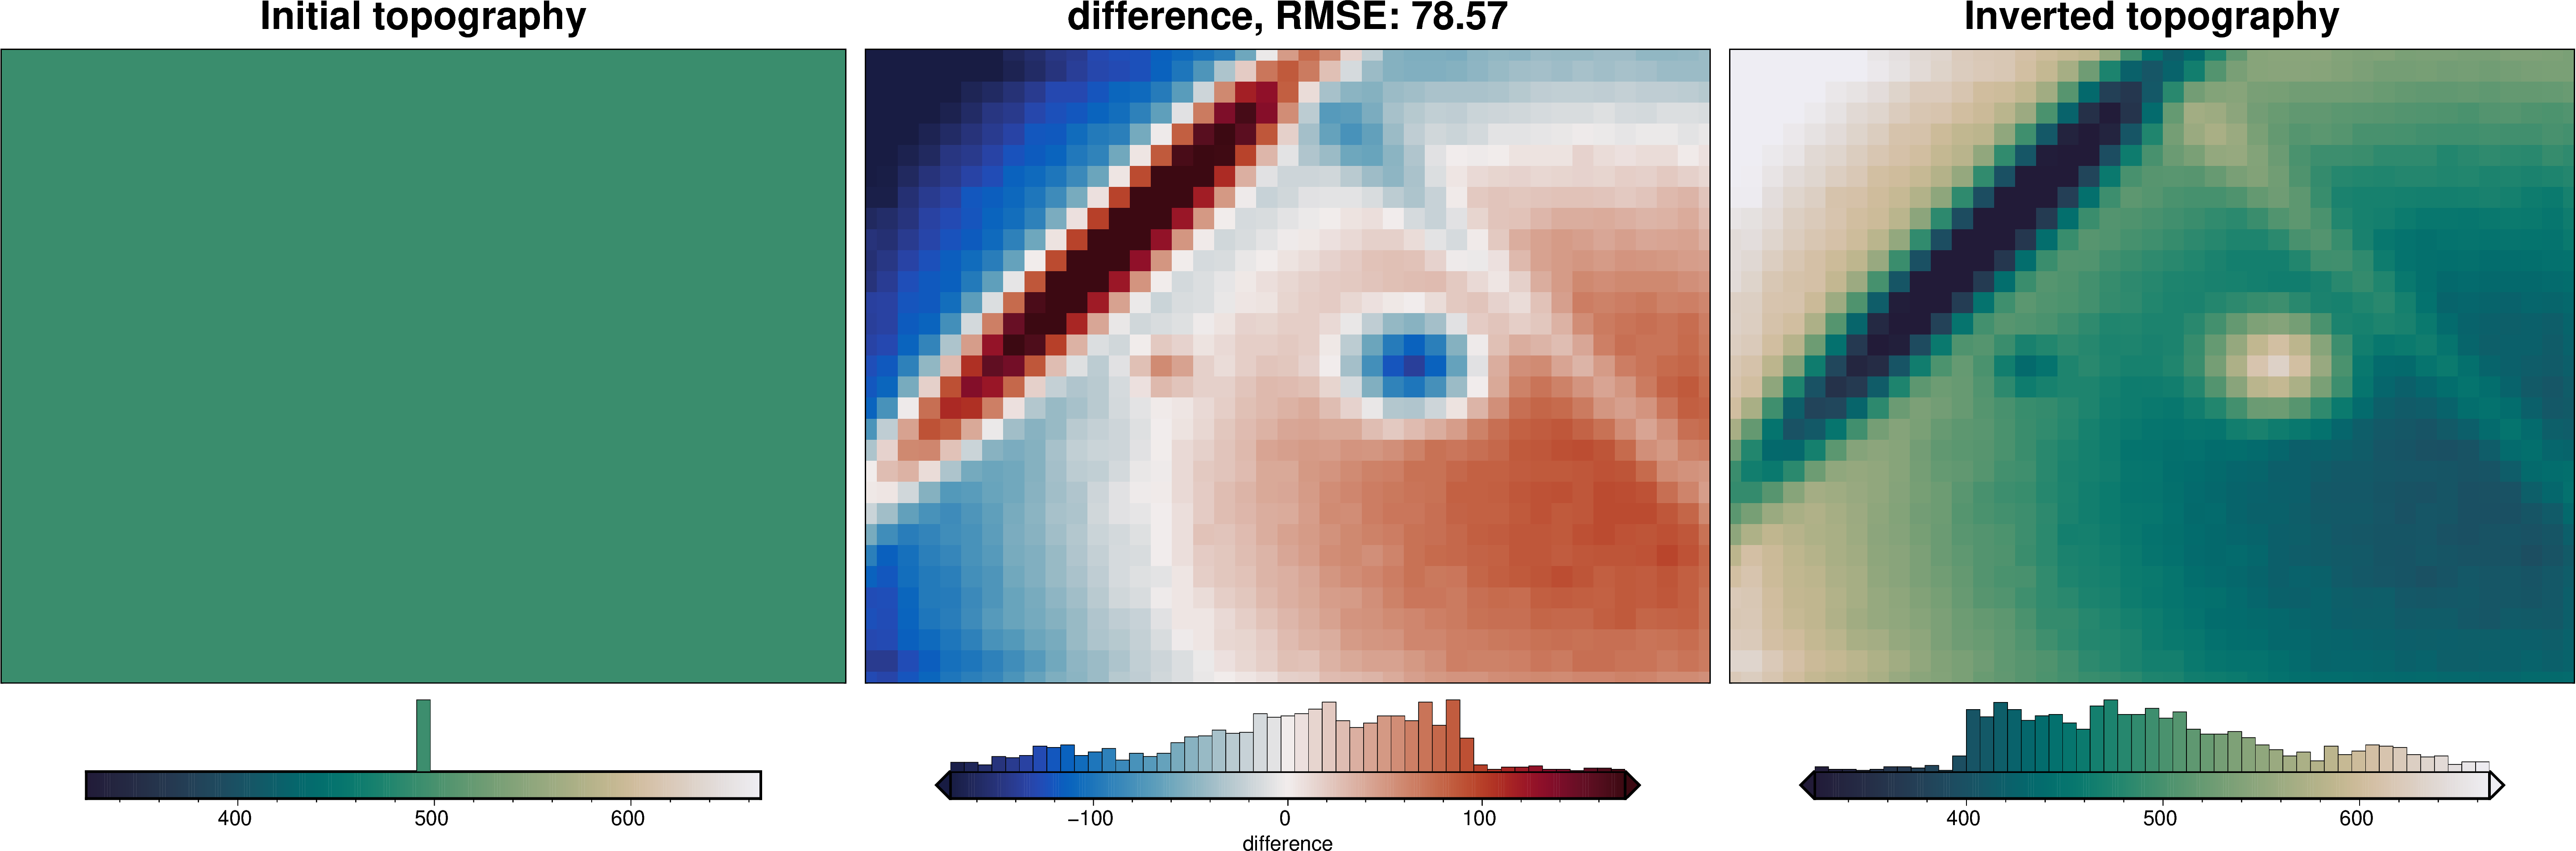

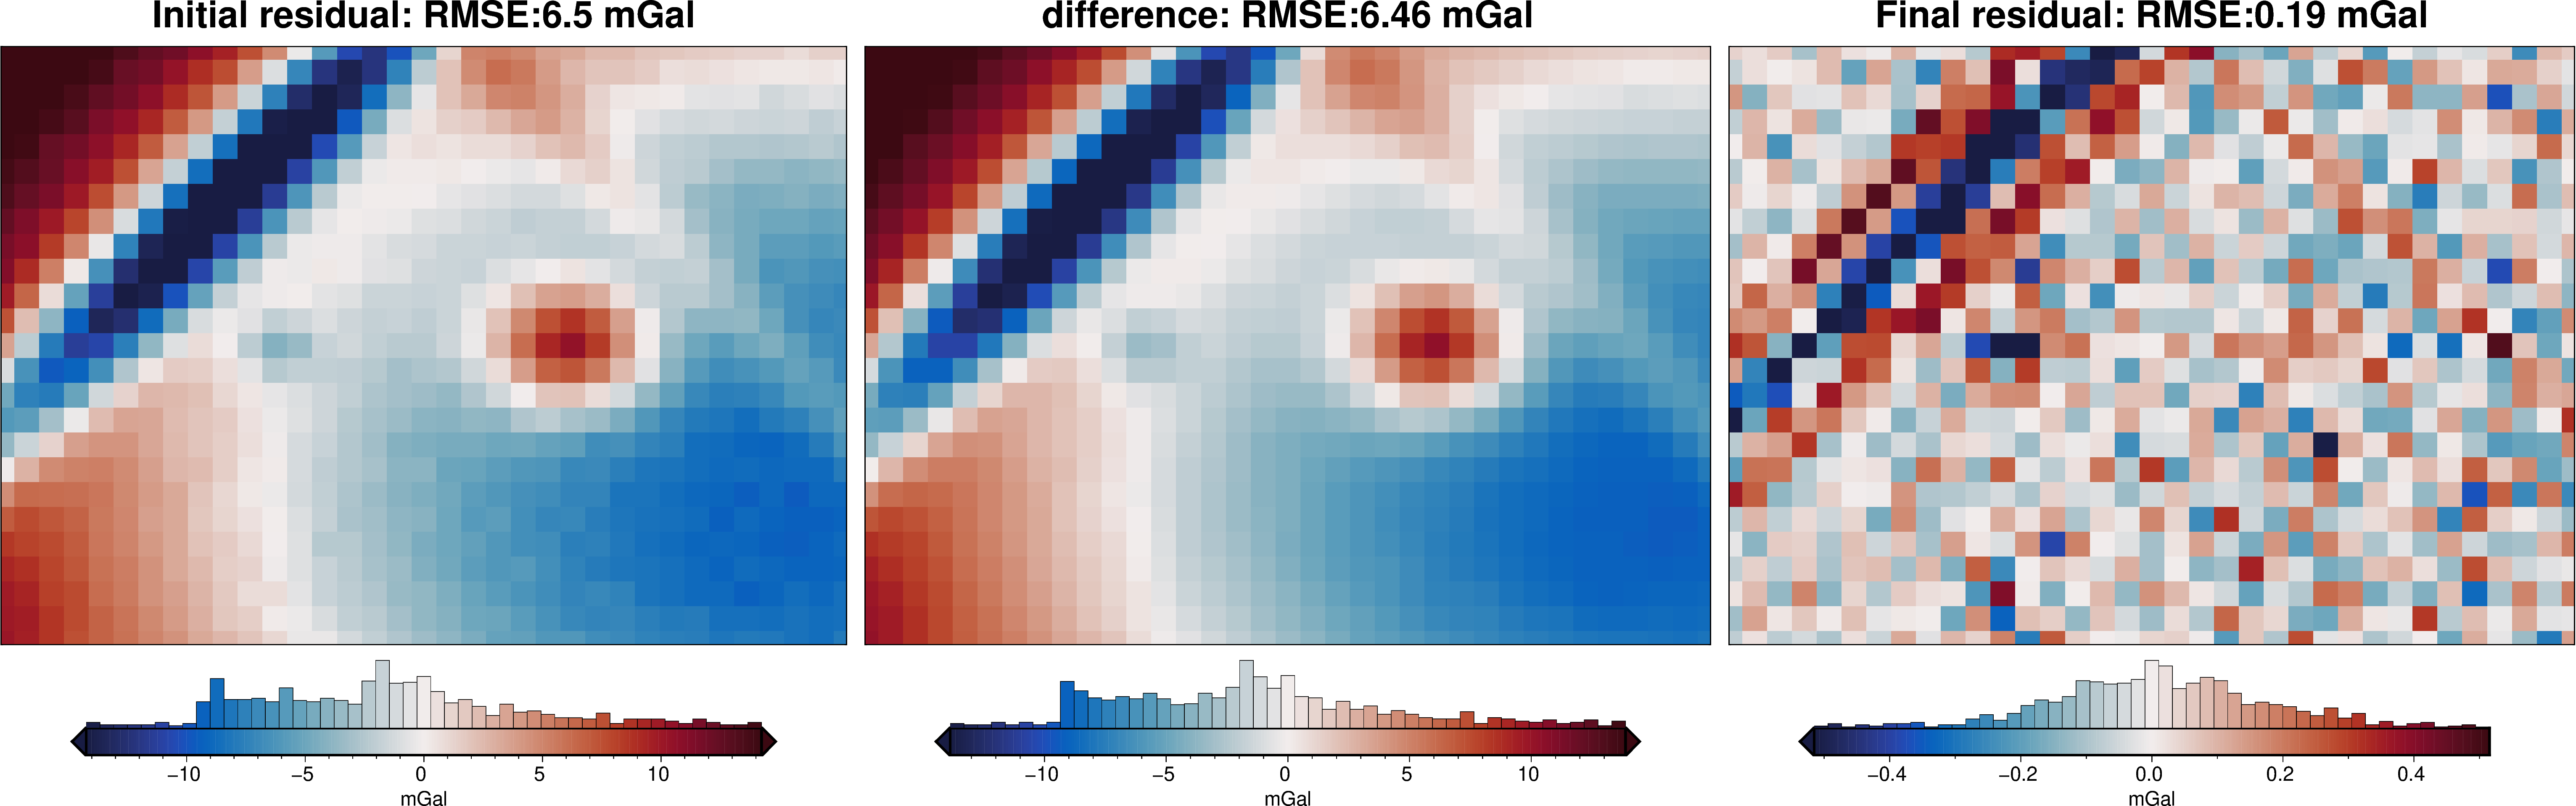

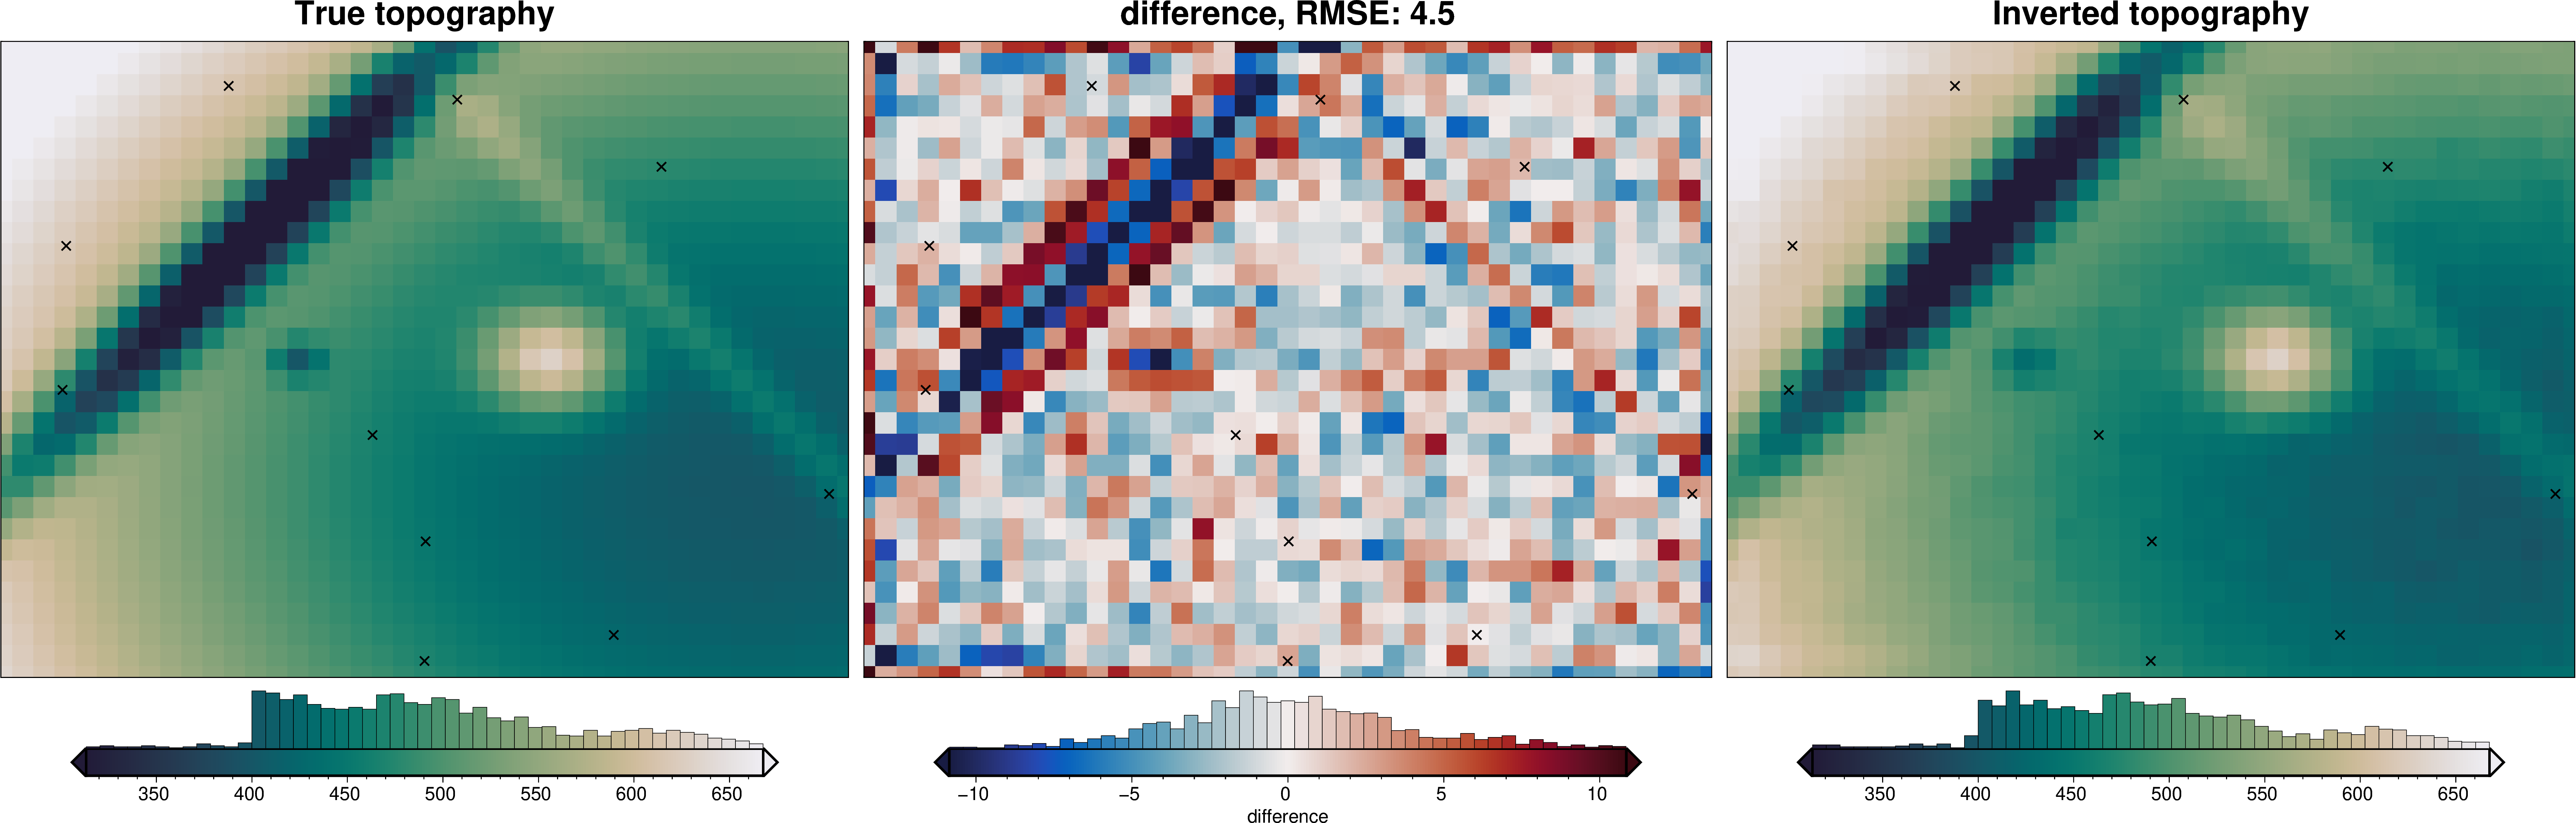

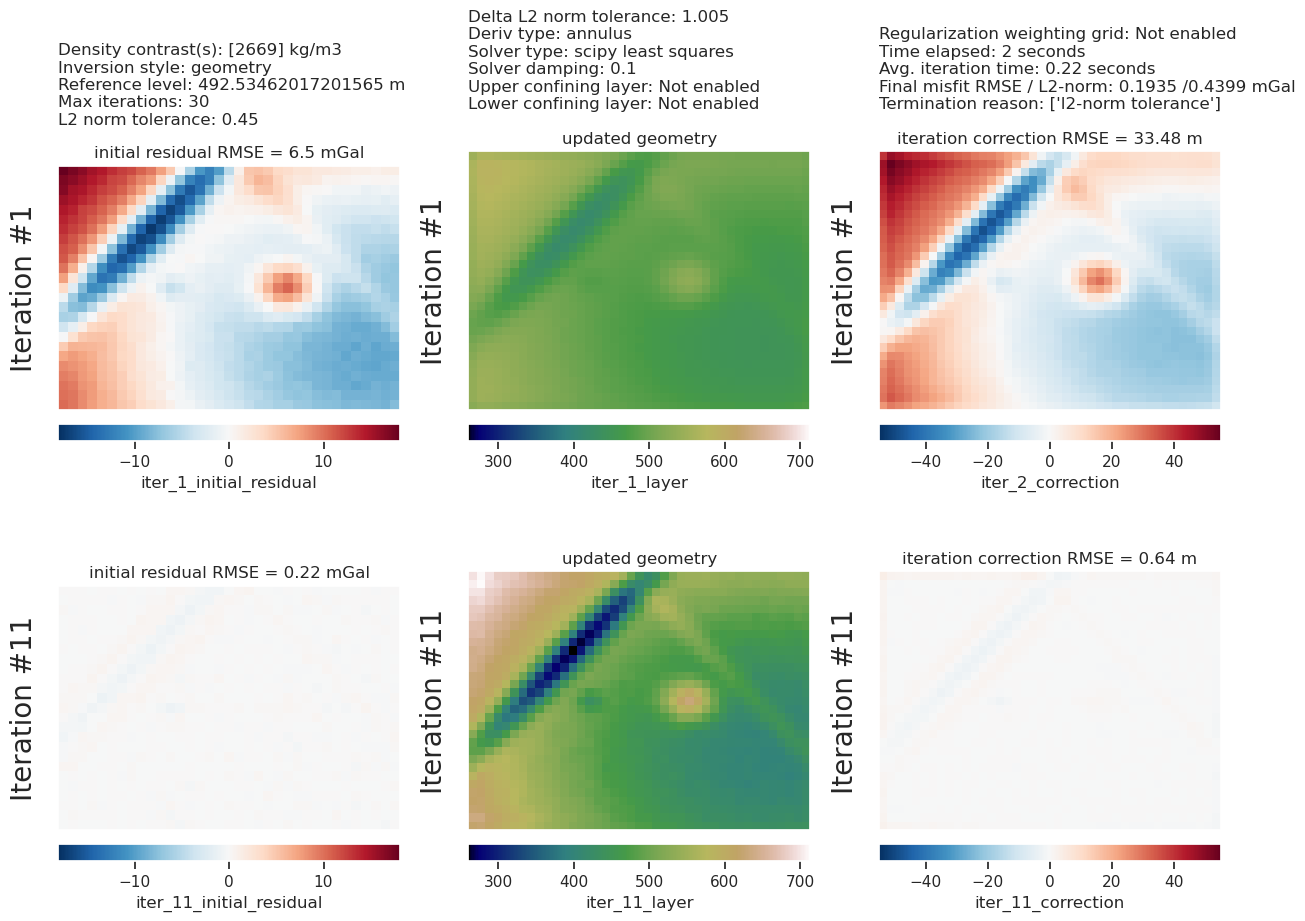

In [13]:
inv_results.plot_inversion_results(iters_to_plot=2)

_ = ptk.grid_compare(
    true_topography,
    inv_results.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

## Run inversion with poor choice of reference level

In [14]:
# set a bad reference level
bad_zref = 300

bad_zref_results = invert4geom.run_inversion_workflow(
    grav_ds=data,
    create_starting_topography=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    density_contrast=true_density_contrast,
    zref=bad_zref,
    fname="../tmp/06_bad_zref",
    starting_topography_kwargs={
        "method": "flat",
        "upwards": bad_zref,
        "region": data.region,
        "spacing": data.spacing,
    },
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    inversion_kwargs={
        "max_iterations": 30,
        "l2_norm_tolerance": 0.45,
        "delta_l2_norm_tolerance": 1.005,
        "solver_damping": 0.1,
    },
)

'forward_gravity' already a variable of `grav_ds`, but is being overwritten since calculate_starting_gravity is True


'reg' already a column of `grav_df`, but is being overwritten since calculate_regional_misfit is True


Iteration:   3%|3         | 1/30 [00:00<?, ?it/s]

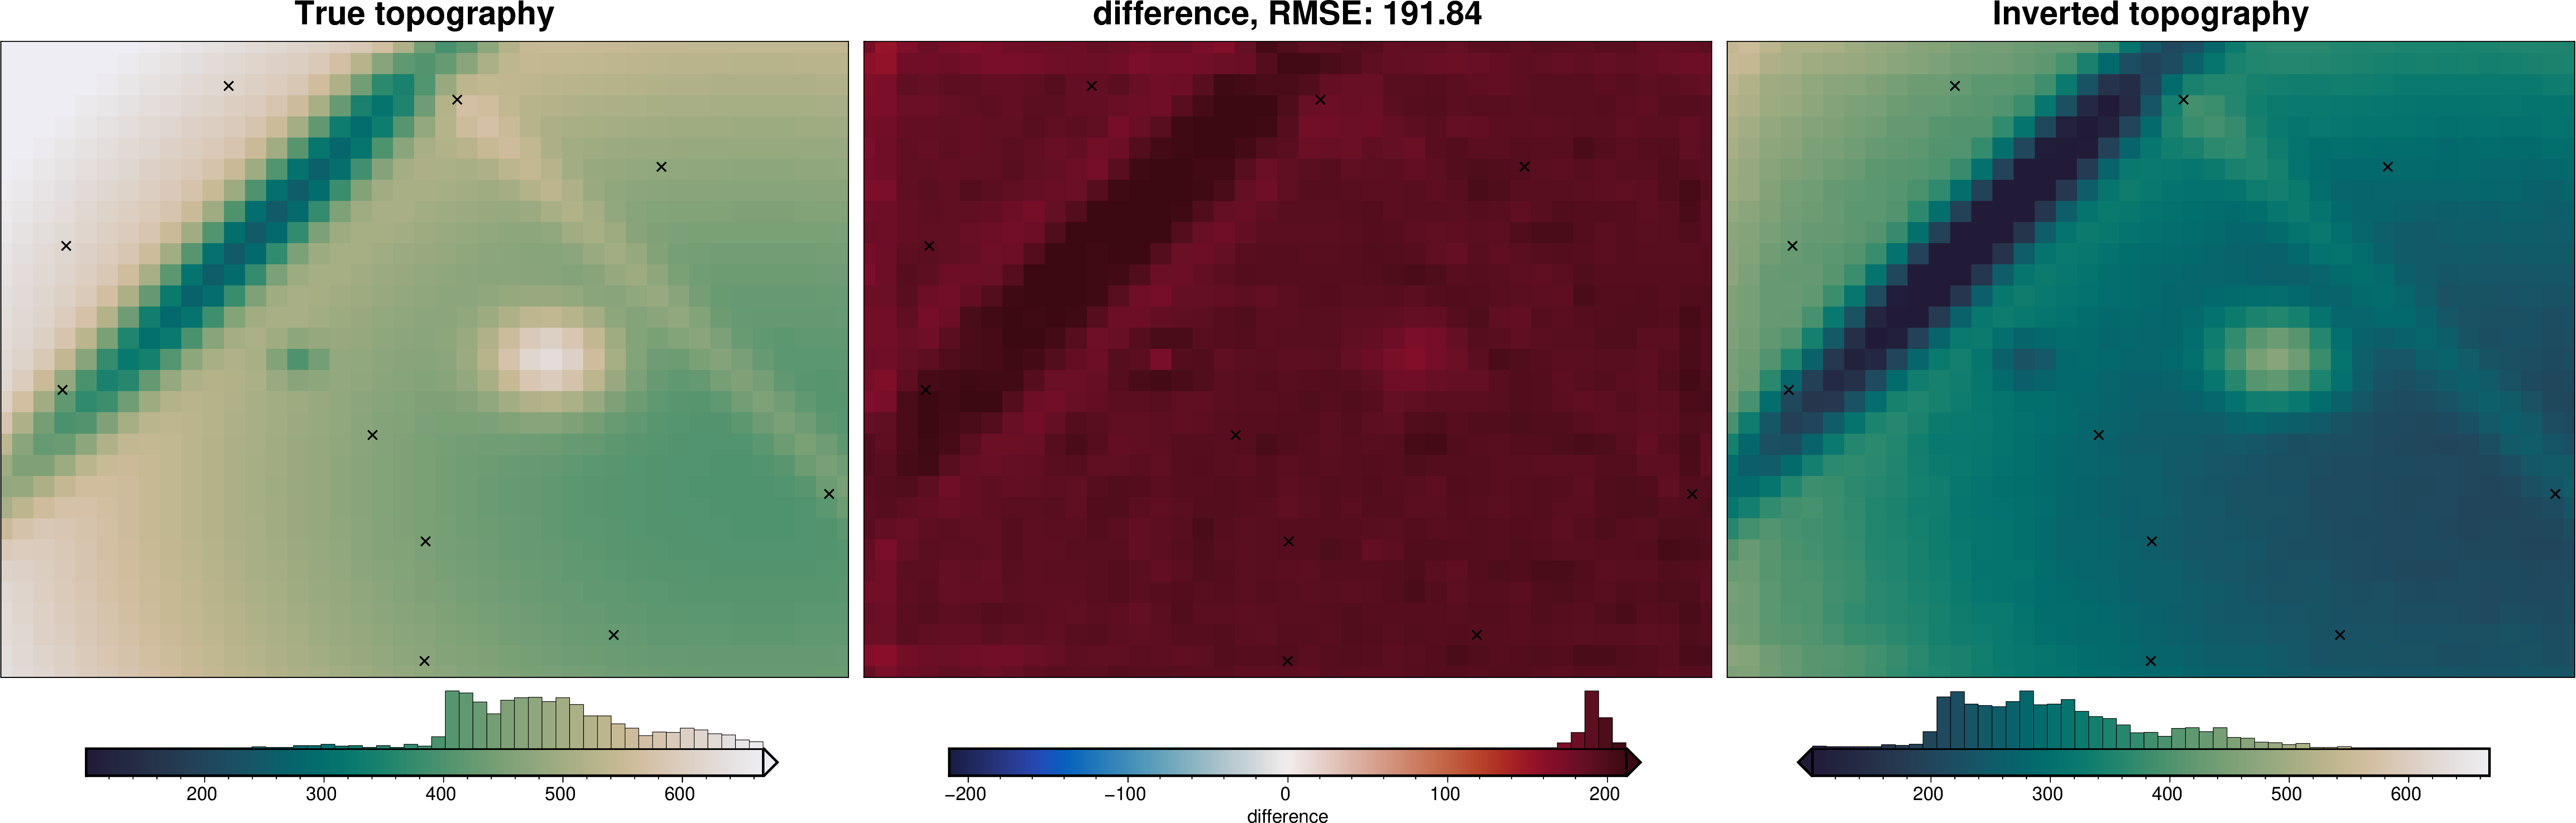

In [15]:
_ = ptk.grid_compare(
    true_topography,
    bad_zref_results.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

This inversion with a zref of 300m  instead of the optimal zref of ~490m, shows that an incorrect zref will result in an inverted topography which vertically offset from the true topography. Estimating and removing a regional component of the gravity misfit may help this, but the zref optimization is an effect tool to reduce these errors.